In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import time
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
#dataset preparation

# Hyperparameters
input_size = 784 # 28x28
num_classes = 10
batch_size = 64

# Load Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))   #to first arg is mean value and second arg is standard deviation
])

# Download and prepare the MNIST dataset
train_dataset = datasets.MNIST(root='mnist_dataset/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='mnist_dataset/', train=False, transform=transform, download=True)

# Split training dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Training Images:


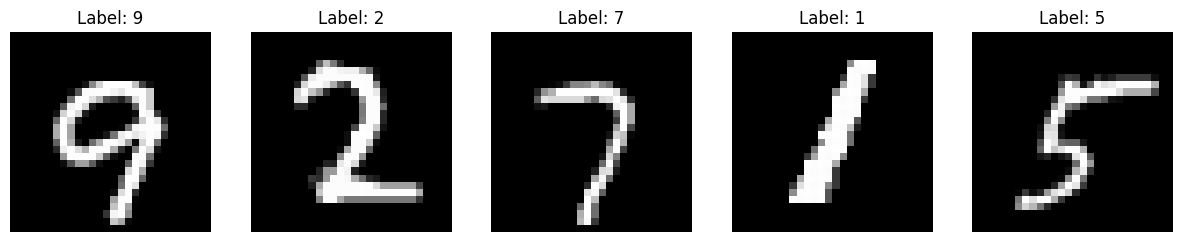

Validation Images:


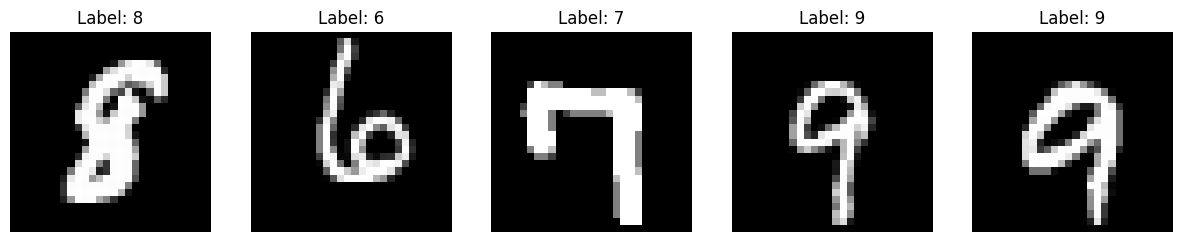

In [3]:
# Function to visualize 5 random images with their labels
def visualize_random_images(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax in axes:
        index = np.random.randint(0, len(dataset))
        img, label = dataset[index]
        img = img.numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Visualize training and validation images
print("Training Images:")
visualize_random_images(train_dataset)
print("Validation Images:")
visualize_random_images(val_dataset)

In [4]:
# Function for training the model
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum().item()
        total += targets.size(0)
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Function for evaluating the model
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            
            # Statistics
            running_loss += loss.item()
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum().item()
            total += targets.size(0)
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [5]:
# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the CNN model
model = CNN().to(device)

In [6]:
#hyperparameter
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 100


Epoch [1/100]: Train Loss: 0.1864, Train Acc: 0.9412, Val Loss: 0.0624, Val Acc: 0.9805
Epoch [2/100]: Train Loss: 0.0524, Train Acc: 0.9840, Val Loss: 0.0638, Val Acc: 0.9802
Epoch [3/100]: Train Loss: 0.0362, Train Acc: 0.9884, Val Loss: 0.0407, Val Acc: 0.9878
Epoch [4/100]: Train Loss: 0.0281, Train Acc: 0.9911, Val Loss: 0.0411, Val Acc: 0.9878
Epoch [5/100]: Train Loss: 0.0217, Train Acc: 0.9930, Val Loss: 0.0423, Val Acc: 0.9882
Epoch [6/100]: Train Loss: 0.0177, Train Acc: 0.9942, Val Loss: 0.0546, Val Acc: 0.9845
Epoch [7/100]: Train Loss: 0.0169, Train Acc: 0.9942, Val Loss: 0.0467, Val Acc: 0.9863
Epoch [8/100]: Train Loss: 0.0105, Train Acc: 0.9967, Val Loss: 0.0410, Val Acc: 0.9898
Epoch [9/100]: Train Loss: 0.0121, Train Acc: 0.9960, Val Loss: 0.0434, Val Acc: 0.9882
Epoch [10/100]: Train Loss: 0.0107, Train Acc: 0.9965, Val Loss: 0.0378, Val Acc: 0.9898
Epoch [11/100]: Train Loss: 0.0077, Train Acc: 0.9976, Val Loss: 0.0567, Val Acc: 0.9868
Epoch [12/100]: Train Loss: 0.

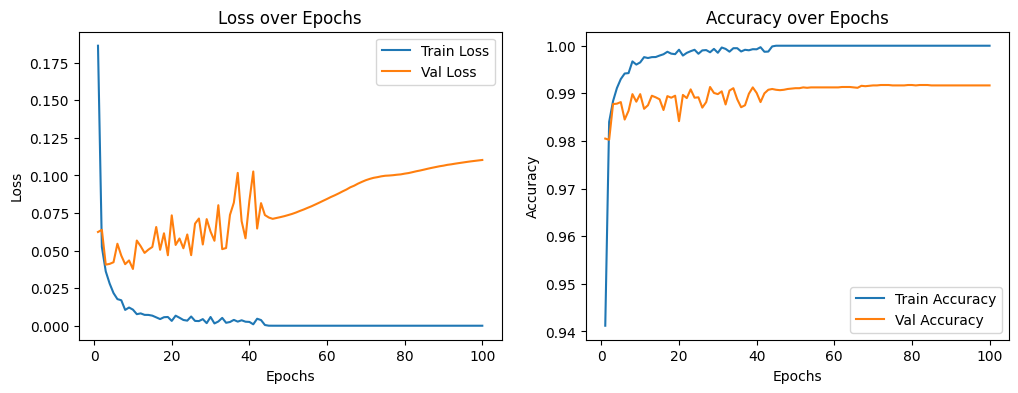

In [8]:
# Record the start time
start_time = time.time()

#start training
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Record the end time
end_time = time.time()
total_time = end_time - start_time

print(f'Total training time: {total_time:.2f} seconds')

# Plotting the training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

Test Loss: 0.1024, Test Accuracy: 0.9914


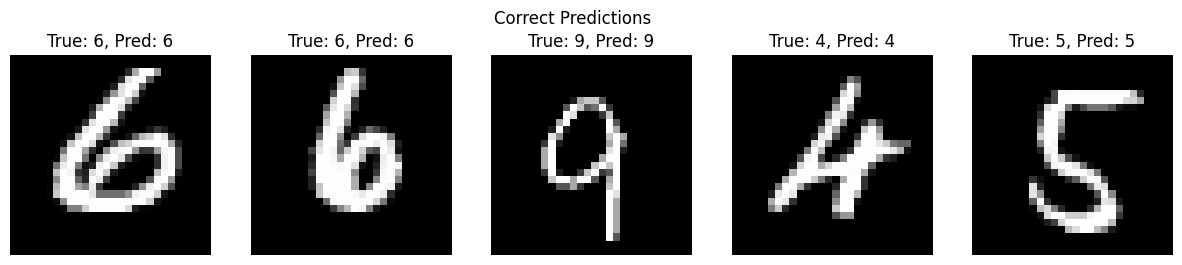

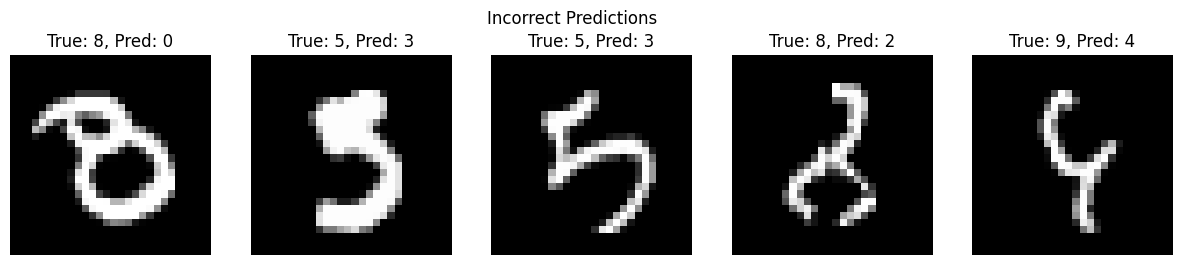

In [9]:
# Evaluate the model on test data and collect predictions
def evaluate_and_collect_predictions(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    correct_images = []
    incorrect_images = []
    correct_labels = []
    incorrect_labels = []
    predicted_labels_correct = []
    predicted_labels_incorrect = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            for i in range(data.size(0)):
                if predicted[i] == targets[i]:
                    correct_images.append(data[i].cpu())
                    correct_labels.append(targets[i].cpu())
                    predicted_labels_correct.append(predicted[i].cpu())
                else:
                    incorrect_images.append(data[i].cpu())
                    incorrect_labels.append(targets[i].cpu())
                    predicted_labels_incorrect.append(predicted[i].cpu())

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, correct_images, incorrect_images, correct_labels, incorrect_labels, predicted_labels_correct, predicted_labels_incorrect

# Call the modified evaluation function
test_loss, test_acc, correct_images, incorrect_images, correct_labels, incorrect_labels, predicted_labels_correct, predicted_labels_incorrect = evaluate_and_collect_predictions(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Function to visualize 5 random correct and incorrect predictions
def visualize_random_predictions(correct_images, incorrect_images, correct_labels, incorrect_labels, predicted_labels_correct, predicted_labels_incorrect):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax in axes:
        idx = np.random.randint(0, len(correct_images))
        img = correct_images[idx].numpy().squeeze()
        true_label = correct_labels[idx].item()
        pred_label = predicted_labels_correct[idx].item()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')
    plt.suptitle('Correct Predictions')
    plt.show()

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax in axes:
        idx = np.random.randint(0, len(incorrect_images))
        img = incorrect_images[idx].numpy().squeeze()
        true_label = incorrect_labels[idx].item()
        pred_label = predicted_labels_incorrect[idx].item()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        ax.axis('off')
    plt.suptitle('Incorrect Predictions')
    plt.show()

# Visualize the predictions
visualize_random_predictions(correct_images, incorrect_images, correct_labels, incorrect_labels, predicted_labels_correct, predicted_labels_incorrect)
